In [1]:
import numpy as np
import pandas as pd
import copy
from dataclasses import dataclass, field

from os import listdir
from os.path import isfile, join

import matplotlib.pyplot as plt
import matplotlib.colors as colors
import matplotlib.cm as cmx

# Utils

In [2]:
def read_instance_data(instances_dir: str, file_path: str) -> (np.array, np.array, np.array):
    with open(instances_dir + file_path, 'r') as f:
        lines = f.readlines()
        n_machines, n_parts = map(int, lines[0].split())
        matrix = np.zeros(shape=(n_machines, n_parts), dtype=int)
        for line in lines[1:]:
            values = list(map(int, line.split()))
            m_id = values[0]
            for i in values[1:]:
                #substract 1 is required if ids of machines start from 1
                matrix[m_id-1][i-1] = 1
    m_ids, p_ids = list(range(1, n_machines+1)), list(range(1, n_parts+1))
    return matrix, m_ids, p_ids

In [3]:
def draw_matrix(matrix: np.array, m_ids: np.array=None, p_ids: np.array=None, title='') -> None:
    n_machines, n_parts = matrix.shape
    fig, ax = plt.subplots(figsize=(n_machines, 7))
    ax.matshow(matrix, cmap='gray_r')
    ax.set_xticks(range(n_parts))
    ax.set_yticks(range(n_machines))
    if p_ids is not None:
        ax.set_xticklabels(p_ids)
    if m_ids is not None:
        ax.set_yticklabels(m_ids)
    if title:
        plt.title(title)
    plt.tight_layout()
    plt.show()

# Model

In [4]:
@dataclass
class Cluster:
    machines: list
    parts: list
    
    def __post_init__(self) -> None:
        self.n_machines = len(self.machines)
        self.n_parts = len(self.parts)
        
    def remove_machine(self, m_id: int) -> None:
        if m_id in self.machines:
            self.machines.remove(m_id)
            self.n_machines -= 1
    
    def add_machine(self, m_id: int) -> None:
        if m_id not in self.machines:
            self.machines.append(m_id)
            self.n_machines += 1
            
    def remove_part(self, p_id: int) -> None:
        if p_id in self.parts:
            self.parts.remove(p_id)
            self.n_parts -= 1
            
    def add_part(self, p_id: int) -> None:
        if p_id not in self.parts:
            self.parts.append(p_id)
            self.n_parts += 1

In [5]:
@dataclass
class Solution:
    instance_name: str
    clusters: list
    matrix: np.array = field(repr=False)
    
    ge: float = field(init=False)
    _n_ones_total: int = field(init=False, repr=False)
    
    def __post_init__(self):
        self._n_ones_total = (self.matrix == 1).sum()
        self.ge = self._obj_func()
        
    def __iter__(self):
        return iter(self.clusters)
    
    def __setitem__(self, index, value):
        self.clusters[index] = value
        self.ge = self._obj_func()
        
    def remove_cluster(self, cluster: Cluster) -> None:
        self.clusters.remove(cluster)
        self.ge = self._obj_func()
        
    def set_clusters(self, clusters: list) -> None:
        self.clusters = clusters
        self.ge = self._obj_func()
        
    def add_clusters(self, clusters: list) -> None:
        self.clusters.extend(clusters)
        self.ge = self._obj_func()
    
    def _obj_func(self) -> float:
        n_ones_in, n_zeros_in = 0, 0
        for cluster in self.clusters:
            for m_id in cluster.machines:
                for p_id in cluster.parts:
                    if self.matrix[m_id-1][p_id-1] == 1:
                        n_ones_in += 1
                    else:
                        n_zeros_in += 1
        return n_ones_in / (self._n_ones_total + n_zeros_in)
    
    def draw(self) -> None:
        result_m_ids = np.concatenate(list(map(lambda cl: cl.machines, self.clusters)))
        result_p_ids = np.concatenate(list(map(lambda cl: cl.parts, self.clusters)))
        m1 = self.matrix[[m_id-1 for m_id in result_m_ids], :]
        m2 = m1[:, [p_id-1 for p_id in result_p_ids]]
        draw_matrix(m2, result_m_ids, result_p_ids, 
                    title=f"{self.instance_name}, GE={self.ge:.4f}")
        
    def save(self) -> None:
        m_cl_dict, p_cl_dict = {}, {}
        for i, cl in enumerate(self.clusters):
            for m_id in cl.machines:
                m_cl_dict[m_id] = i
            for p_id in cl.parts:
                p_cl_dict[p_id] = i
        m_cl_mapping = ' '.join(f"{m_id}_{cl_id}" 
                            for m_id, cl_id in sorted(m_cl_dict.items()))
        p_cl_mapping = ' '.join(f"{p_id}_{cl_id}" 
                            for p_id, cl_id in sorted(p_cl_dict.items()))
        result = f"{m_cl_mapping}\n{p_cl_mapping}"
        with open('./results/' + self.instance_name[:-3] + 'sol', 'w') as file:
            file.write(result)

# Neighborhood structures for Shaking:
* Split a random cluster into two
* Merge two random clusters into one
* Split out the first cell from random cluster

In [6]:
def split_cluster(cluster: Cluster) -> (Cluster, Cluster):
    split_m_idx = np.random.choice(range(1, len(cluster.machines)))
    split_p_idx = np.random.choice(range(1, len(cluster.parts)))
    first_cluster = Cluster(cluster.machines[:split_m_idx], cluster.parts[:split_p_idx])
    second_cluster = Cluster(cluster.machines[split_m_idx:], cluster.parts[split_p_idx:])
    return first_cluster, second_cluster

def random_split(sol: Solution) -> Solution:
    print("split")
    valid_clusters = [cl for cl in sol.clusters 
                      if cl.n_machines > 1 and cl.n_parts > 1]
    cluster_to_split = np.random.choice(valid_clusters)
    splitted_clusters = split_cluster(cluster_to_split)
    new_sol = copy.deepcopy(sol)
    new_sol.remove_cluster(cluster_to_split)
    new_sol.add_clusters(splitted_clusters)
    return new_sol

In [7]:
def merge_clusters(cluster_a: Cluster, cluster_b: Cluster) -> Cluster:
    return Cluster(cluster_a.machines + cluster_b.machines, 
                   cluster_a.parts + cluster_b.parts)

def random_merge(sol: Solution) -> Solution:
    print("merge")
    if len(sol.clusters) == 1:
        return sol
    clusters_to_merge = np.random.choice(sol.clusters, 2, replace=False)
    merged_cluster = merge_clusters(*clusters_to_merge)
    new_sol = copy.deepcopy(sol)
    for cl in clusters_to_merge:
        new_sol.remove_cluster(cl)
    new_sol.add_clusters([merged_cluster])
    return new_sol

In [8]:
def first_cell_out_split(cluster: Cluster) -> (Cluster, Cluster):
    one_cell_cluster = Cluster([cluster.machines[0]], [cluster.parts[0]])
    remain_cluster = copy.deepcopy(cluster)
    remain_cluster.remove_machine(remain_cluster.machines[0])
    remain_cluster.remove_part(remain_cluster.parts[0])
    return one_cell_cluster, remain_cluster

def random_cell_out_split(sol: Solution) -> Solution:
    print('cell out split')
    valid_clusters = [cl for cl in sol.clusters 
                      if cl.n_machines > 1 and cl.n_parts > 1]
    cluster_to_split = np.random.choice(valid_clusters)
    splitted_clusters = first_cell_out_split(cluster_to_split)
    new_sol = copy.deepcopy(sol)
    new_sol.remove_cluster(cluster_to_split)
    new_sol.add_clusters(splitted_clusters)
    return new_sol

# Neighborhood structures for VND:
* Move a machine from one cluster to another
* Move a part from one cluster to another

In [9]:
def move_machine(m_id: int, cluster_from: Cluster, cluster_to: Cluster) -> (Cluster, Cluster):
    new_a, new_b = copy.deepcopy(cluster_from), copy.deepcopy(cluster_to)
    new_a.remove_machine(m_id)
    new_b.add_machine(m_id)
    return new_a, new_b

def move_machines(sol: Solution) -> Solution:
    best_sol, best_ge = sol, sol.ge
    for a in sol:
        if a.n_machines == 1:
            continue
        for b in sol:
            if a != b:
                for m_id in a.machines:
                    new_a, new_b = move_machine(m_id, a, b)
                    current_sol = copy.deepcopy(sol)
                    current_sol[sol.clusters.index(a)] = new_a
                    current_sol[sol.clusters.index(b)] = new_b
                    current_ge = current_sol.ge
                    if current_ge > best_ge:
                        best_sol, best_ge = current_sol, current_ge
    return best_sol

In [10]:
def move_part(p_id: int, cluster_from: Cluster, cluster_to: Cluster) -> (Cluster, Cluster):
    new_a, new_b = copy.deepcopy(cluster_from), copy.deepcopy(cluster_to)
    new_a.remove_part(p_id)
    new_b.add_part(p_id)
    return new_a, new_b

def move_parts(sol: Solution) -> Solution:
    best_sol, best_ge = sol, sol.ge
    for a in sol:
        if a.n_parts == 1:
            continue
        for b in sol:
            if a != b:
                for p_id in a.parts:
                    new_a, new_b = move_part(p_id, a, b)
                    current_sol = copy.deepcopy(sol)
                    current_sol[sol.clusters.index(a)] = new_a
                    current_sol[sol.clusters.index(b)] = new_b
                    current_ge = current_sol.ge
                    if current_ge > best_ge:
                        best_sol, best_ge = current_sol, current_ge
    return best_sol

# VND

In [11]:
def vnd(sol: Solution) -> Solution:
    operators = [move_machines, move_parts]
    l, l_max = 0, len(operators)
    best_sol, best_ge = sol, sol.ge    
    iters = 1
    while l < l_max:
        iters += 1
        current_sol = operators[l](best_sol)
        current_ge = current_sol.ge
        if current_ge > best_ge:
            best_sol, best_ge = current_sol, current_ge
            l = 0
        else:
            l += 1
    return best_sol

# General VNS

In [12]:
def vns(sol: Solution) -> Solution:
    shaking_operators = [random_cell_out_split, random_merge, random_split]
    k, k_max = 0, len(shaking_operators)
    best_sol, best_ge = sol, sol.ge
    iters = 1
    while k < k_max:
        print(f"VNS Iteration = {iters}")
        iters += 1
        sh_sol = shaking_operators[k](best_sol)
        vnd_sol = vnd(sh_sol)
        vnd_ge = vnd_sol.ge
        if vnd_ge > best_ge:
            best_sol, best_ge = vnd_sol, vnd_ge
            print(f"New best solution: GE = {best_ge:.4f}")
            print('*' * 35)
            k = 0
        else:
            k += 1
    return best_sol

# Test instances

In [13]:
instances_dir = './resources/instances/'
instances = [f for f in listdir(instances_dir) 
             if isfile(join(instances_dir, f)) 
             and (f.endswith(".txt"))]

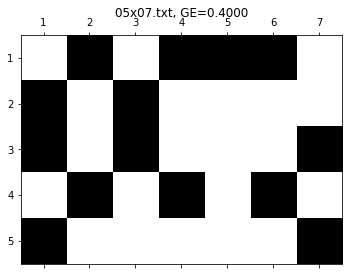

VNS Iteration = 1
cell out split
New best solution: GE = 0.8235
***********************************
VNS Iteration = 2
cell out split
VNS Iteration = 3
merge
VNS Iteration = 4
split


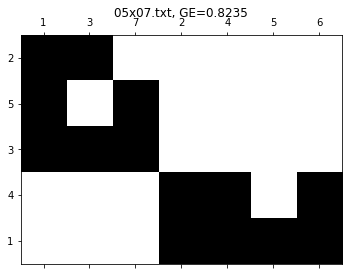

Cluster(machines=[2, 5, 3], parts=[1, 3, 7])
Cluster(machines=[4, 1], parts=[2, 4, 5, 6])
**************************************************


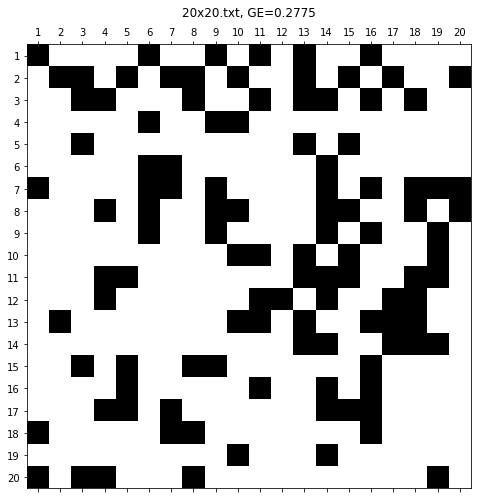

VNS Iteration = 1
cell out split
New best solution: GE = 0.3636
***********************************
VNS Iteration = 2
cell out split
New best solution: GE = 0.3990
***********************************
VNS Iteration = 3
cell out split
New best solution: GE = 0.4183
***********************************
VNS Iteration = 4
cell out split
VNS Iteration = 5
merge
VNS Iteration = 6
split


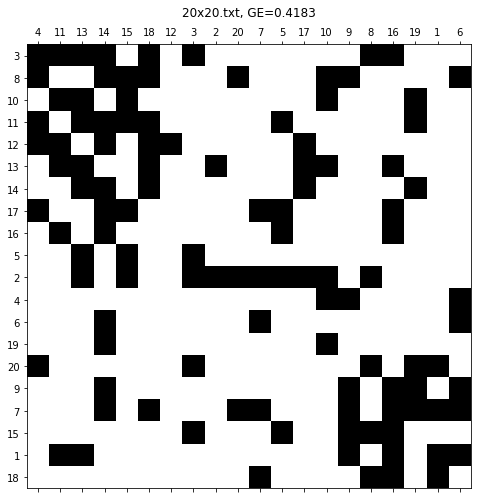

Cluster(machines=[3, 8, 10, 11, 12, 13, 14, 17, 16, 5], parts=[4, 11, 13, 14, 15, 18])
Cluster(machines=[2], parts=[12, 3, 2, 20, 7, 5, 17])
Cluster(machines=[4, 6, 19], parts=[10])
Cluster(machines=[20, 9, 7, 15, 1, 18], parts=[9, 8, 16, 19, 1, 6])
**************************************************


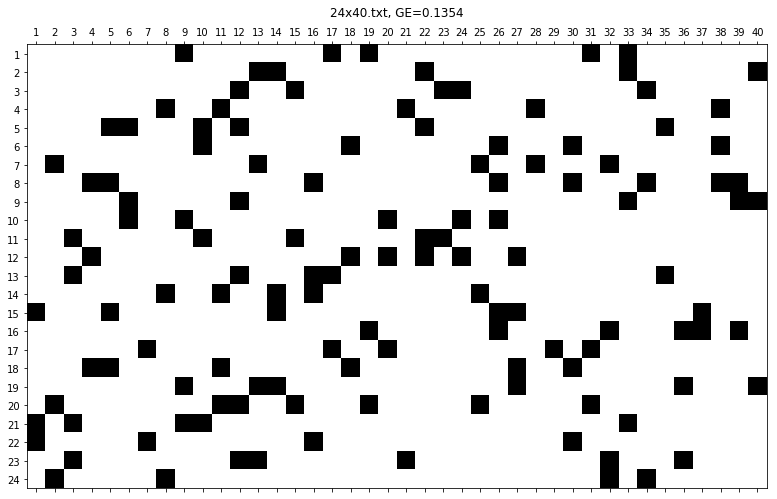

VNS Iteration = 1
cell out split
New best solution: GE = 0.2055
***********************************
VNS Iteration = 2
cell out split
New best solution: GE = 0.2689
***********************************
VNS Iteration = 3
cell out split
New best solution: GE = 0.3204
***********************************
VNS Iteration = 4
cell out split
New best solution: GE = 0.3750
***********************************
VNS Iteration = 5
cell out split
New best solution: GE = 0.4010
***********************************
VNS Iteration = 6
cell out split
New best solution: GE = 0.4197
***********************************
VNS Iteration = 7
cell out split
New best solution: GE = 0.4263
***********************************
VNS Iteration = 8
cell out split
New best solution: GE = 0.4393
***********************************
VNS Iteration = 9
cell out split
VNS Iteration = 10
merge
VNS Iteration = 11
split


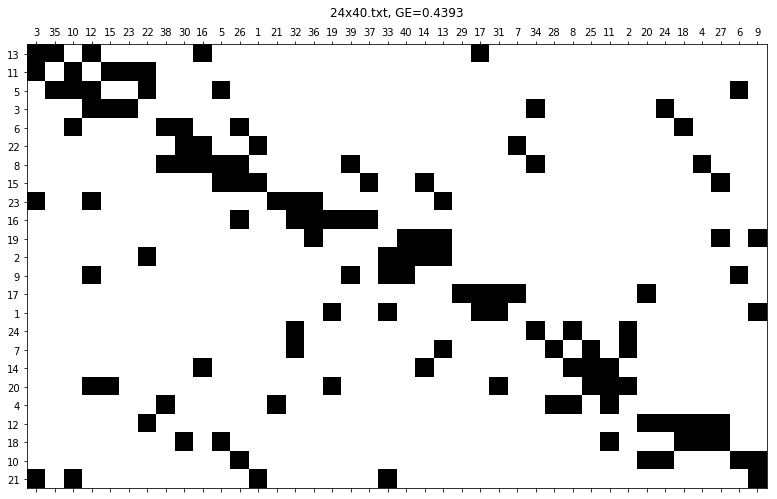

Cluster(machines=[13, 11, 5, 3], parts=[3, 35, 10, 12, 15, 23, 22])
Cluster(machines=[6, 22, 8, 15], parts=[38, 30, 16, 5, 26, 1])
Cluster(machines=[23, 16], parts=[21, 32, 36, 19, 39, 37])
Cluster(machines=[19, 2, 9], parts=[33, 40, 14, 13])
Cluster(machines=[17, 1], parts=[29, 17, 31, 7])
Cluster(machines=[24], parts=[34])
Cluster(machines=[7, 14, 20, 4], parts=[28, 8, 25, 11, 2])
Cluster(machines=[12, 18], parts=[20, 24, 18, 4, 27])
Cluster(machines=[10, 21], parts=[6, 9])
**************************************************


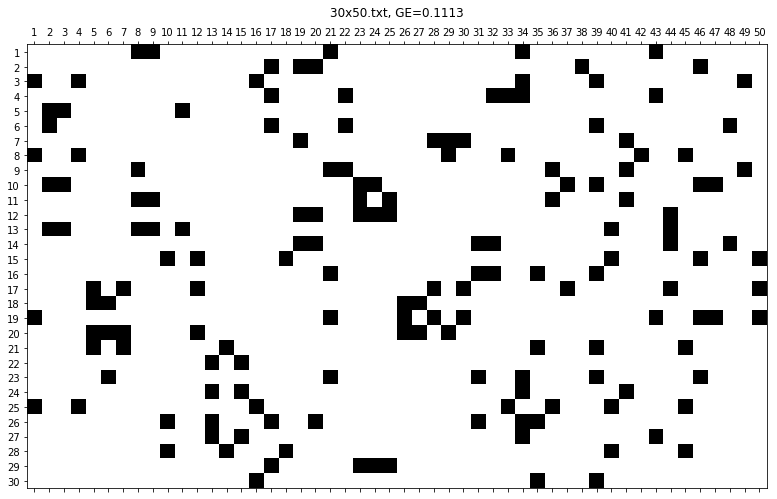

VNS Iteration = 1
cell out split
New best solution: GE = 0.1846
***********************************
VNS Iteration = 2
cell out split
New best solution: GE = 0.2429
***********************************
VNS Iteration = 3
cell out split
New best solution: GE = 0.3081
***********************************
VNS Iteration = 4
cell out split
New best solution: GE = 0.3391
***********************************
VNS Iteration = 5
cell out split
New best solution: GE = 0.3590
***********************************
VNS Iteration = 6
cell out split
New best solution: GE = 0.3942
***********************************
VNS Iteration = 7
cell out split
New best solution: GE = 0.4190
***********************************
VNS Iteration = 8
cell out split
New best solution: GE = 0.4416
***********************************
VNS Iteration = 9
cell out split
New best solution: GE = 0.4703
***********************************
VNS Iteration = 10
cell out split
New best solution: GE = 0.4926
***********************************

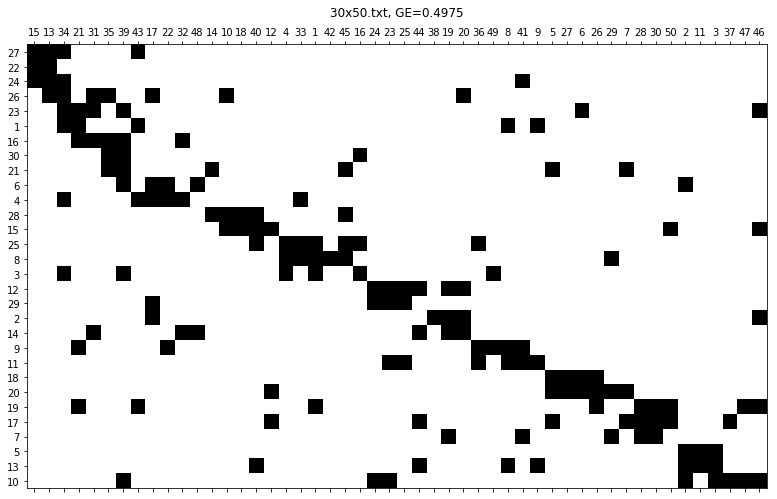

Cluster(machines=[27, 22, 24], parts=[15, 13])
Cluster(machines=[26, 23, 1, 16, 30, 21], parts=[34, 21, 31, 35, 39])
Cluster(machines=[6, 4], parts=[43, 17, 22, 32, 48])
Cluster(machines=[28, 15], parts=[14, 10, 18, 40, 12])
Cluster(machines=[25, 8, 3], parts=[4, 33, 1, 42, 45, 16])
Cluster(machines=[12, 29], parts=[24, 23, 25, 44])
Cluster(machines=[2, 14], parts=[38, 19, 20])
Cluster(machines=[9, 11], parts=[36, 49, 8, 41, 9])
Cluster(machines=[18, 20], parts=[5, 27, 6, 26, 29, 7])
Cluster(machines=[19, 17, 7], parts=[28, 30, 50])
Cluster(machines=[5, 13], parts=[2, 11, 3])
Cluster(machines=[10], parts=[37, 47, 46])
**************************************************


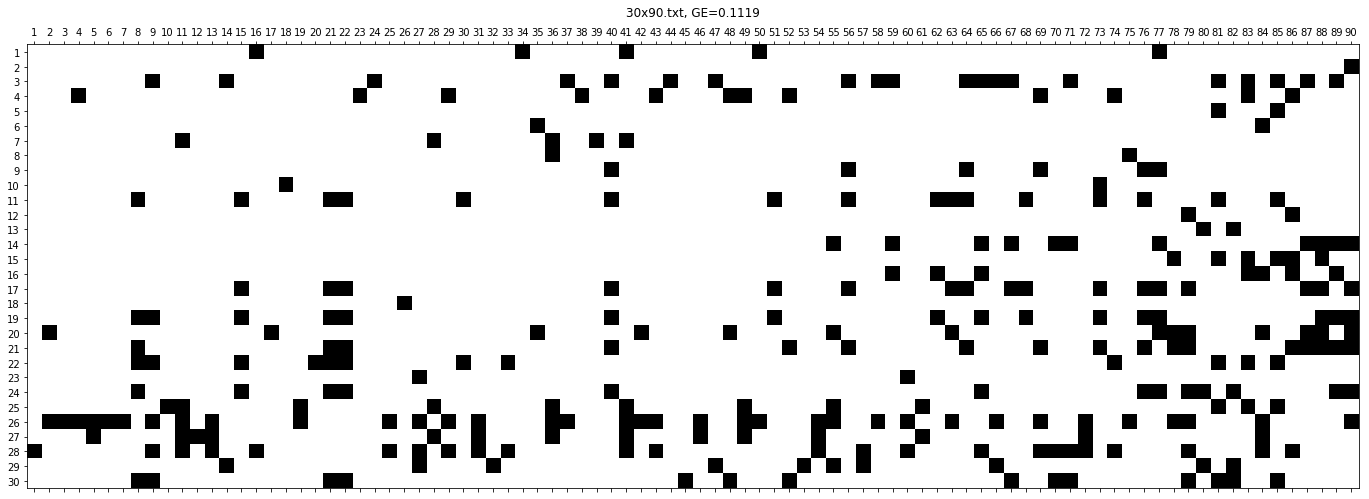

VNS Iteration = 1
cell out split
New best solution: GE = 0.1947
***********************************
VNS Iteration = 2
cell out split
New best solution: GE = 0.3213
***********************************
VNS Iteration = 3
cell out split
New best solution: GE = 0.3425
***********************************
VNS Iteration = 4
cell out split
New best solution: GE = 0.3819
***********************************
VNS Iteration = 5
cell out split
New best solution: GE = 0.3889
***********************************
VNS Iteration = 6
cell out split
New best solution: GE = 0.3896
***********************************
VNS Iteration = 7
cell out split
New best solution: GE = 0.4009
***********************************
VNS Iteration = 8
cell out split
New best solution: GE = 0.4091
***********************************
VNS Iteration = 9
cell out split
VNS Iteration = 10
merge
VNS Iteration = 11
split
New best solution: GE = 0.4120
***********************************
VNS Iteration = 12
cell out split
VNS Iteration = 

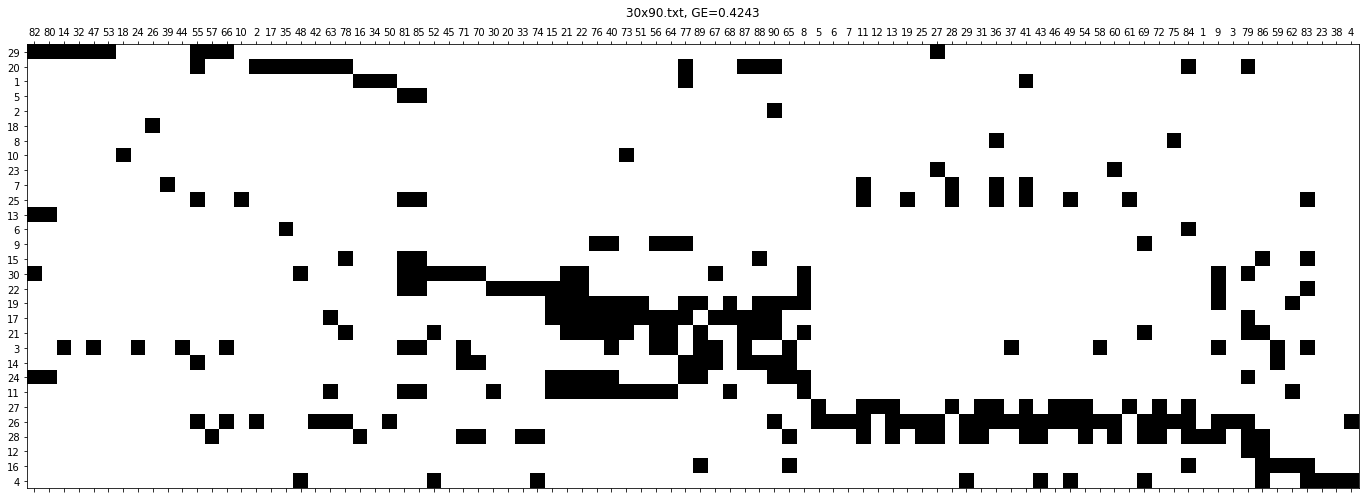

Cluster(machines=[29], parts=[82, 80, 14, 32, 47, 53, 18, 24, 26, 39, 44, 55, 57, 66, 10])
Cluster(machines=[20], parts=[2, 17, 35, 48, 42, 63, 78])
Cluster(machines=[1], parts=[16, 34, 50])
Cluster(machines=[5, 2, 18, 8, 10, 23, 7, 25, 13, 6, 9, 15], parts=[81])
Cluster(machines=[30], parts=[85, 52, 45, 71, 70])
Cluster(machines=[22], parts=[30, 20, 33, 74])
Cluster(machines=[19, 17, 21, 3, 14, 24, 11], parts=[15, 21, 22, 76, 40, 73, 51, 56, 64, 77, 89, 67, 68, 87, 88, 90, 65, 8])
Cluster(machines=[27, 26, 28], parts=[5, 6, 7, 11, 12, 13, 19, 25, 27, 28, 29, 31, 36, 37, 41, 43, 46, 49, 54, 58, 60, 61, 69, 72, 75, 84, 1, 9, 3, 79])
Cluster(machines=[12, 16], parts=[86, 59, 62])
Cluster(machines=[4], parts=[83, 23, 38, 4])
**************************************************


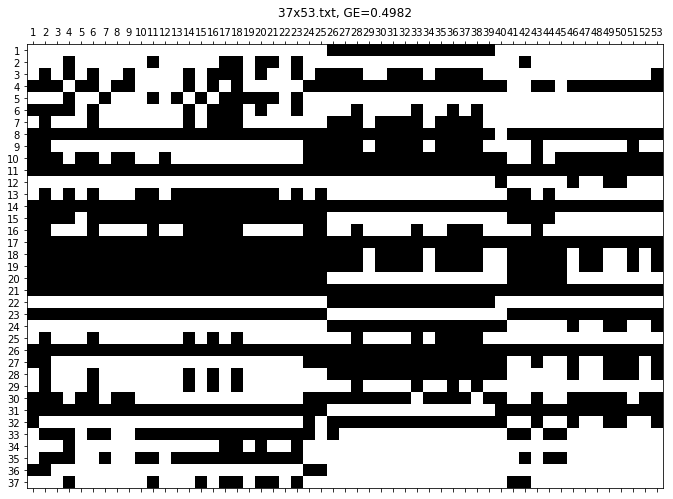

VNS Iteration = 1
cell out split
New best solution: GE = 0.5859
***********************************
VNS Iteration = 2
cell out split
VNS Iteration = 3
merge
VNS Iteration = 4
split


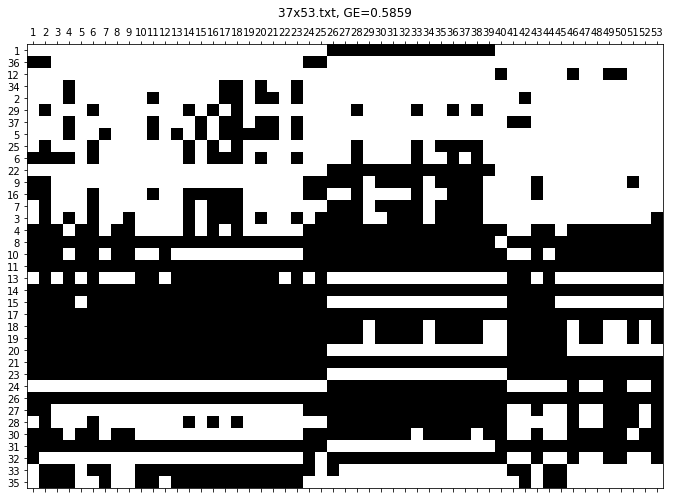

Cluster(machines=[1, 36, 12, 34, 2, 29, 37, 5, 25, 6, 22, 9, 16, 7], parts=[1])
Cluster(machines=[3, 4, 8, 10, 11, 13, 14, 15, 17, 18, 19, 20, 21, 23, 24, 26, 27, 28, 30, 31, 32, 33, 35], parts=[2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53])
**************************************************


In [14]:
results = pd.DataFrame([], columns=['GE'])
for instance_name in instances:
    matrix, m_ids, p_ids = read_instance_data(instances_dir, instance_name)
    init_sol = Solution(instance_name, [Cluster(machines=m_ids, parts=p_ids)], matrix)
    init_sol.draw()
    final_sol = vns(init_sol)
    final_sol.draw()
    for cl in final_sol:
        print(cl)
    print('*' * 50)
    final_sol.save()
    results.loc[instance_name] = [final_sol.ge]

In [15]:
pd.set_option('precision', 4)
results.transpose()

,05x07.txt,20x20.txt,24x40.txt,30x50.txt,30x90.txt,37x53.txt
GE,0.8235,0.4183,0.4393,0.4975,0.4243,0.5859
